In [7]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt


In [80]:
mainpath = Path('/bdd/CFMIP/CFMIP_OBS_LOCAL/GOCCP_v3/instant_SR_CR_DR/v3.1.2/2019/day/')
path = list(mainpath.glob("instant_SR_CR_DR_2019-12-11*_CFMIP1_*.nc"))
len(path)

d = xr.open_dataset(path[1])

In [81]:
d

<xarray.Dataset>
Dimensions:             (altitude: 40, it: 63495, nv: 2)
Dimensions without coordinates: altitude, it, nv
Data variables: (12/21)
    longitude           (it) float32 ...
    latitude            (it) float32 ...
    alt_mid             (altitude) float32 ...
    alt_bound           (nv, altitude) float32 ...
    time                (it) float32 ...
    SE                  (it) float32 ...
    ...                  ...
    TEMP                (it, altitude) float32 ...
    surf_OPAQ           (it) float32 ...
    instant_OPAQ        (it, altitude) float32 ...
    NSIDC               (it) float32 ...
    RMS                 (it) float32 ...
    instant_Phase       (it, altitude) float32 ...
Attributes:
    Description:         GOCCP_instant_SR_DR_CR_file
    Date:                2019-12-11T21-54-31ZD
    Version:             GOCCP v3.1
    Authors:             Rodrigo GUZMAN, Gregory CESANA, Helene CHEPFER, LMD/...
    Scientific_contact:  helene.chepfer@lmd.polytechnique.fr
    Technical_support:   rodrigo.guzman@lmd.polytechnique.fr
    Creation_date:       20200417
    Website:             http://climserv.ipsl.polytechnique.fr/cfmip-obs.html
    References:          Guzman et al., 2017, Direct atmosphere opacity obser...

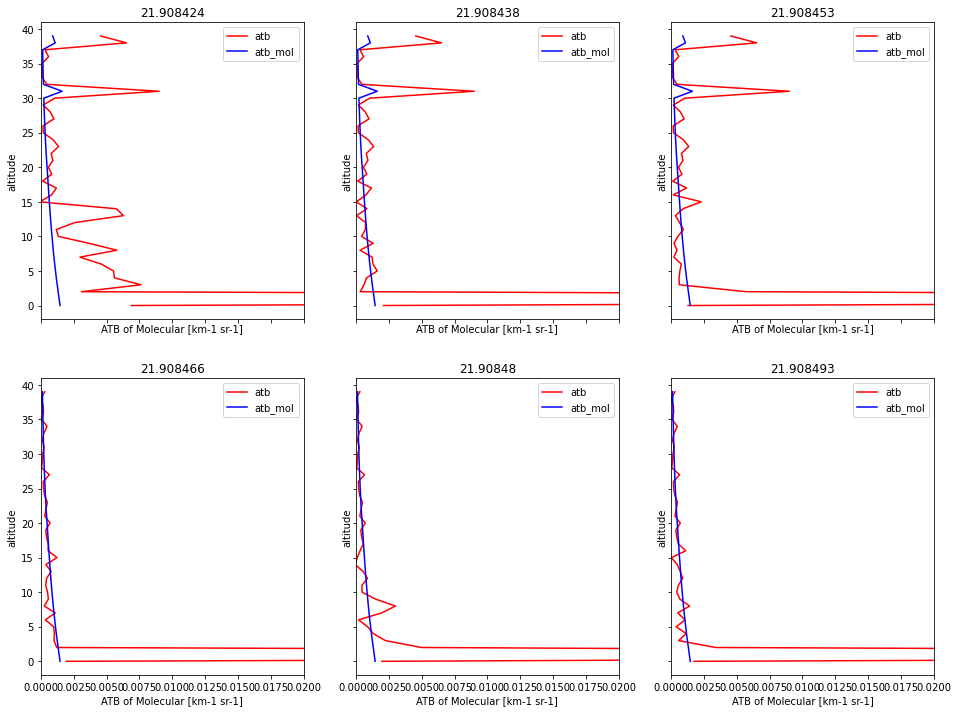

In [82]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=[16,12])
for i, ax in enumerate(axs.flatten()):
    d.ATB[i,:].plot.line(y='altitude',color='r', label='atb', ax=ax)
    d.ATB_mol[i,:].plot.line(y='altitude', color='b', label='atb_mol', ax=ax)
    ax.legend()
    ax.set(title=str(d.time[i].values))
    ax.set_xlim(0, 0.02)

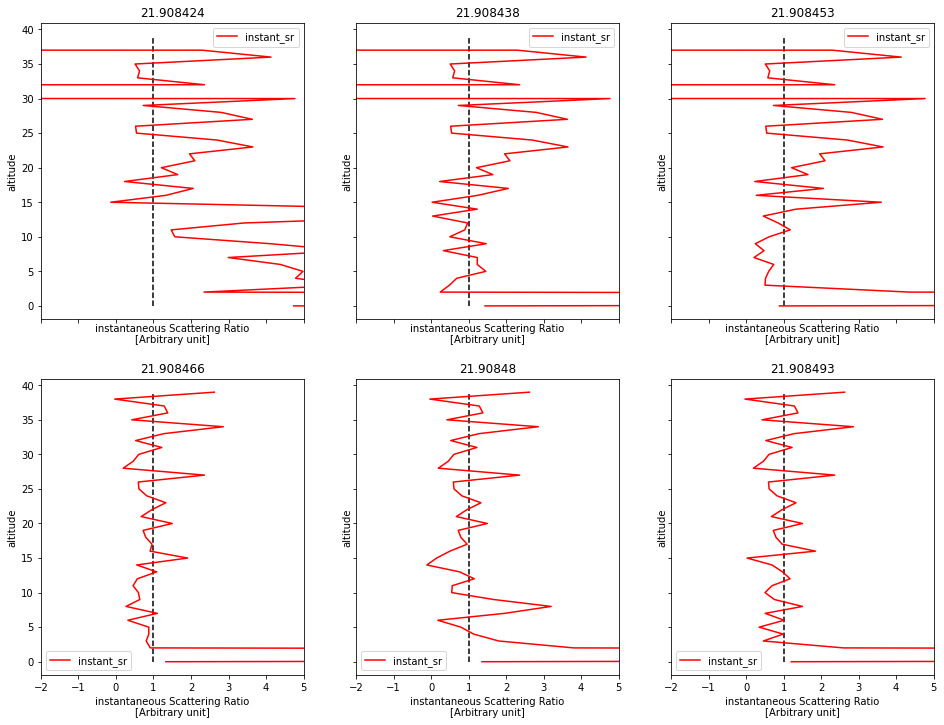

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=[16,12])
for i, ax in enumerate(axs.flatten()):
    d.instant_SR[i,:].plot.line(y='altitude',color='r', label='instant_sr', ax=ax)
    #(d.ATB[i,:]/d.ATB_mol[i,:]).plot.line(y='altitude',color='b', label='sr', ax=ax)
    ax.vlines(1, ymin=d.altitude[0], ymax=d.altitude.max(), linestyle='--', color='k')
    ax.legend()
    ax.set_xlim(-2, 5)
    ax.set(title=str(d.time[i].values))

In [11]:
d.altitude

<xarray.DataArray 'altitude' (altitude: 40)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39])
Dimensions without coordinates: altitude

In [58]:
#d.altitude.values*1e3, d.TEMP.values[1,:]+273.15
C = pressure_from_temperature(d.TEMP.values[1,:]+273.15, d.altitude.values*1e3)    


[     -0.           -9842.78702948  -19685.57405896  -29528.36108845
  -39371.14811793  -49213.93514741  -59056.72217689  -68899.50920638
  -78742.29623586  -88585.08326534  -98427.87029482 -108270.6573243
 -118113.44435379 -127956.23138327 -137799.01841275 -147641.80544223
 -157484.59247172 -167327.3795012  -177170.16653068 -187012.95356016
 -196855.74058964 -206698.52761913 -216541.31464861 -226384.10167809
 -236226.88870757 -246069.67573705 -255912.46276654 -265755.24979602
 -275598.0368255  -285440.82385498 -295283.61088447 -305126.39791395
 -314969.18494343 -324811.97197291 -334654.75900239 -344497.54603188
 -354340.33306136 -364183.12009084 -374025.90712032 -383868.69414981]


<ipython-input-57-f3dd66d7228b>:9: RuntimeWarning: overflow encountered in exp
  C=np.exp(M*g*alt/R*To)


In [54]:
pression

array([101325.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.])

In [59]:
C


array([ 1., inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf])

In [92]:
from math import exp, log
def isa(alt):
    if alt <= 11000:
        pressure = 101325 * (1 - 2.2556e-5*alt)**5.25616
    else:
        pressure = 0.223356 * 101325 * exp(-0.000157688*(alt-11000))
    return pressure

def MolATB_from_PT(P,T,alt,w):
    const = (5.45e-32/1.38e-23)*(w*1e-3/0.55)**(-4.09)
    beta = const*np.float(P/T)
    alpha = 2*beta/0.119
    tau = np.zeros_like(beta)
    for i in range(1, alt.shape[0]):
        tau[i] = tau[i-1] + alpha[i] * (alt[i] - alt[i-1])
        
   
    #attenuation = beta*exp(-2*tau)
    return beta, tau#attenuation


def equiq_hydro(lat, alt):
    lat = np.deg2rad(lat)
    acc_gravity = 9.78032*(1+5.2885e-3*(np.sin(lat))**2 - 5.9e-6*(np.sin(2*lat))**2)
    r0 = 2*acc_gravity/(3.085462e-6 + 2.27e-9*np.cos(2*lat) - 2e-12*np.cos(4*lat))
    g0 = 9.80665
    #geopt_for_ipral['geopt_height'] = geopt_for_ipral["geopt"]/g0
    #geopt_for_ipral['altitude'] = (geopt_for_ipral['geopt_height']*r0)/(acc_gravity*r0/g0 - geopt_for_ipral['geopt_height'])
    M = 28.966E-3 
    R = 8.314510
    T = (15 + 273.15)
    const = -(M*g0)/(R*T)
    p0 = 101325
    pression = p0*np.exp(const*alt)
    return pression


In [177]:
pressure = [isa(alt*1e3) for alt in d.altitude.values]
MolATBcompute = MolATB_from_PT(pressure, d.TEMP[100,:].values+273.16, d.altitude.values*1e3, 532)

In [263]:
pression = pression(d.latitude.values, d.altitude.values*1e3)

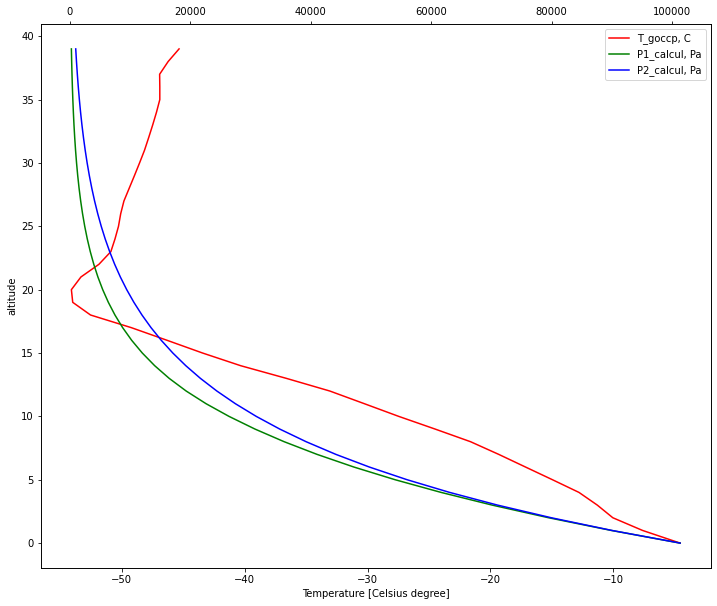

In [265]:
fig, ax=plt.subplots(figsize=[12,10])
d.TEMP[0,:].plot.line(y='altitude', color='r', label='T_goccp, C', ax=ax)
#ax.legend()
ax2= ax.twiny()
ax2.plot(pressure, d.altitude.values, label='P1_calcul, Pa', color='g')
ax2.plot(pression, d.altitude.values, label='P2_calcul, Pa', color='b')
#ax2.legend(loc=0)
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax.legend(lines, labels, loc=0)

[Text(0.5, 1.0, 'Compare Molecular Attn Backscatter between GOCCP and Theoretical compute')]

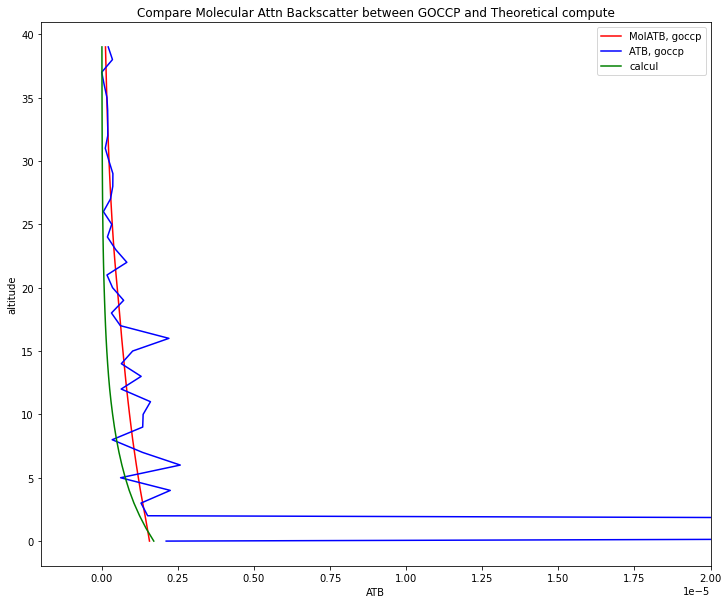

In [178]:
fig, ax=plt.subplots(figsize=[12,10])
(d.ATB_mol[100,:]*1e-3).plot.line(y='altitude',label='MolATB, goccp', color='r', ax=ax)
(d.ATB[100,:]*1e-3).plot.line(y='altitude',label='ATB, goccp', color='b', ax=ax)
ax.plot(MolATBcompute, d.altitude.values, label='calcul', color='g')
ax.legend()
ax.set_xlim(-2e-6, 2e-5)
ax.set(title='Compare Molecular Attn Backscatter between GOCCP and Theoretical compute')

In [103]:
alt_ref = (d.altitude>=33)&(d.altitude<=35)

In [104]:
alt_ref

<xarray.DataArray 'altitude' (altitude: 40)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False])
Dimensions without coordinates: altitude

In [62]:
import pandas as pd
from pathlib import Path
oparmol=pd.read_pickle(Path('/homedata/nmpnguyen/OPAR/Processed/LIO3T/2019-01-21_simul.pkl'))
oparatb=pd.read_pickle(Path("/homedata/nmpnguyen/OPAR/Processed/LIO3T/2019-01-21_00532.p00532.s_ATB.pkl"))
oparraw = xr.open_dataset(Path('/home/nmpnguyen/OPAR/LIO3T.daily/2019-01-21.nc4'))

In [63]:
oparatb

,0,1,2,3,4,5,6,7,8,9,...,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053
2019-01-21 16:45:08,0.0,2.539606e-11,1.026721e-10,2.282609e-10,3.869070e-10,5.748682e-10,8.243947e-10,1.083250e-09,1.338352e-09,1.697950e-09,...,-2.236257e-08,3.626686e-08,5.585157e-08,1.674079e-08,1.146847e-07,-2.836664e-09,-2.245082e-08,1.678477e-08,9.534786e-08,7.575946e-08
2019-01-21 16:47:10,0.0,2.632545e-11,1.086496e-10,2.375487e-10,4.047526e-10,6.096200e-10,8.550813e-10,1.146255e-09,1.420453e-09,1.756284e-09,...,-2.997453e-09,1.694936e-08,9.680803e-08,5.692162e-08,-2.299344e-08,-3.007308e-09,5.703376e-08,-2.303873e-08,7.714919e-08,1.703853e-08
2019-01-21 16:49:12,0.0,2.697961e-11,1.098957e-10,2.405359e-10,4.078466e-10,6.097922e-10,8.619501e-10,1.144714e-09,1.443428e-09,1.743394e-09,...,3.499778e-08,3.502078e-08,1.577332e-08,-2.278258e-08,-2.279753e-08,3.511285e-08,-3.506344e-09,5.449272e-08,-3.510944e-09,9.328247e-08
2019-01-21 16:51:13,0.0,2.863240e-11,1.164931e-10,2.544753e-10,4.205905e-10,6.211789e-10,8.672882e-10,1.132471e-09,1.414211e-09,1.770397e-09,...,-3.118292e-09,1.592302e-08,-6.029000e-08,-4.126121e-08,1.595441e-08,-2.222197e-08,-2.223655e-08,-3.132650e-09,-4.139674e-08,-2.228031e-08
2019-01-21 16:53:15,0.0,2.879796e-11,1.161844e-10,2.515249e-10,4.203650e-10,6.317461e-10,8.892212e-10,1.139829e-09,1.471408e-09,1.808372e-09,...,-4.232241e-08,1.565117e-08,3.500795e-08,9.310855e-08,-3.689888e-09,1.569232e-08,5.449730e-08,-3.697155e-09,-3.699579e-09,3.516904e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-21 20:50:22,0.0,2.256637e-12,9.215703e-12,2.002359e-11,3.526908e-11,5.176756e-11,7.284289e-11,9.682026e-11,1.255963e-10,1.554208e-10,...,6.183766e-09,-3.141137e-09,6.191894e-09,5.912256e-10,5.916138e-10,5.920020e-10,4.336242e-09,-3.153528e-09,-3.155595e-09,5.935564e-10
2019-01-21 20:52:24,0.0,1.894205e-12,7.778530e-12,1.718046e-11,2.907081e-11,4.398643e-11,6.175493e-11,8.354187e-11,1.072298e-10,1.323309e-10,...,6.504063e-09,-4.118228e-09,-4.120933e-09,3.476738e-09,1.957947e-09,4.371605e-10,8.052799e-09,-2.610404e-09,-1.087047e-09,-1.087760e-09
2019-01-21 20:54:25,0.0,1.557385e-12,6.490155e-12,1.462645e-11,2.458908e-11,3.728507e-11,5.297988e-11,6.927744e-11,8.988408e-11,1.102263e-10,...,-2.193620e-09,2.924509e-09,3.649634e-10,-9.163713e-10,1.647858e-09,-2.200832e-09,4.218220e-09,2.936045e-09,-9.193812e-10,3.666427e-10
2019-01-21 20:56:27,0.0,1.815917e-12,7.350839e-12,1.606469e-11,2.719001e-11,4.100787e-11,5.873866e-11,7.617376e-11,9.856246e-11,1.220953e-10,...,-1.066019e-09,-1.066719e-09,-2.532582e-09,-1.068121e-09,3.332437e-09,1.214292e-08,-2.539238e-09,1.869024e-09,7.754008e-09,3.343379e-09


(0.0, 5e-06)

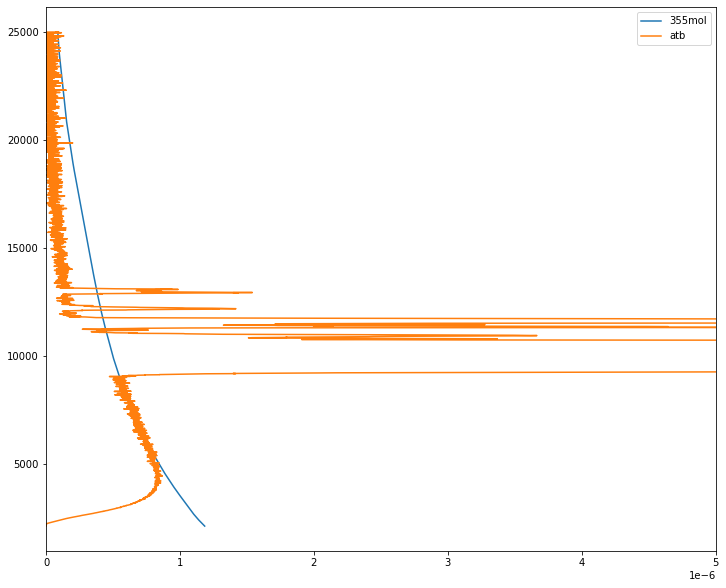

In [65]:
beta532mol = oparmol['beta532mol'].unstack(level=1)
beta532mol = beta532mol.iloc[:,:oparatb.shape[1]]
oparalt = beta532mol.columns


fig, ax = plt.subplots(figsize=[12,10])
ax.plot(beta532mol.iloc[0,:], oparalt, label='355mol')
ax.plot(oparatb.iloc[0,:], oparalt, label='atb')
ax.legend()
#zoom en-dessous de 5km
#ax.set_ylim(5000,7000)
ax.set_xlim(0, 0.5e-5)

In [85]:
oparalt_ref = (oparalt>=5000) & (oparalt<=6000)


In [74]:
np.nanmean((oparatb.iloc[0,oparalt_ref].values/beta532mol.iloc[0,oparalt_ref].values).astype("float"))

0.9789002949999993

In [75]:
y = beta355mol.iloc[0,oparalt_ref].values
x1 = oparatb.iloc[0,oparalt_ref].values
x2 = oparalt[oparalt_ref]
#--------------------------> Equation de régression: f(z) = K.exp(-z)
# np.polyfit -> log(y) = log(K)+log(exp(-Z))
curve_fit = np.polyfit(x1, np.log(y), 1)
print(curve_fit)
yy = np.exp(curve_fit[1])*np.exp(curve_fit[0]*x1)
plt.plot(x1, oparalt[oparalt_ref], label='x1', color='r')
plt.plot(y, oparalt[oparalt_ref], label='y', color='g')
plt.plot(yy, oparalt[oparalt_ref], label='yy', color='b')
plt.legend()

IndexError: Boolean index has wrong length: 3054 instead of 1527

(0.0, 5e-06)

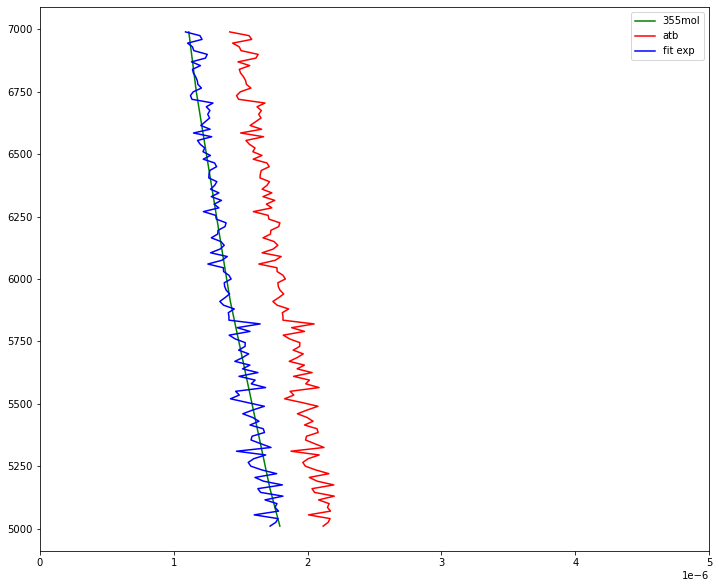

In [15]:
#------------------------------> Appliquer CURVE_FIT et tracer un plot de comparaison 
oparalt_ref = (oparalt>=5000) & (oparalt<=7000)
yy = np.exp(curve_fit[1])*np.exp(curve_fit[0]*oparatb.iloc[0,:])
fig, ax = plt.subplots(figsize=[12,10])
ax.plot(beta355mol.iloc[0,oparalt_ref], oparalt[oparalt_ref], label='355mol', color='g')
ax.plot(oparatb.iloc[0,oparalt_ref], oparalt[oparalt_ref], label='atb', color='r')
ax.plot(yy[oparalt_ref], oparalt[oparalt_ref], label='fit exp', color='b')
ax.legend()
ax.set_xlim(0, 0.5e-5)

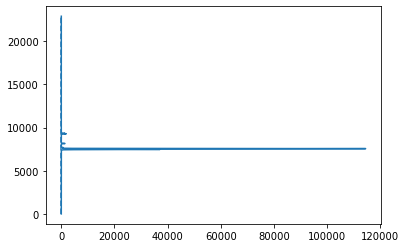

In [253]:
plt.plot(yy/beta355mol.iloc[0,:].values, oparalt)
plt.vlines(1, ymin=0, ymax=oparalt[-1], linestyle='--')

In [76]:
#------------------------> Calculer la pression par 2 méthodes: 
#------Equilibre hydrostatique-------- 
pression = oparmol['pression'].unstack(level=1)
Tempe = oparmol['ta'].unstack(level=1)
#molAttn1 = MolATB_from_PT(pression.iloc[0,:].values, Tempe.iloc[0,:].values, alt=pression.columns+2160,w=532)
molAttn1 = oparmol['beta532mol'].unstack(level=1)

In [105]:
#------International Standard Atmosphere-------
pressure = [isa(z+2160) for z in Tempe.columns]
alt=np.array(pression.columns+2160)
const = (5.45e-32/1.38e-23)*(532*1e-3/0.55)**(-4.09)
beta = const*(pressure/np.array(Tempe.iloc[0,:].values)).astype('float')
alpha = 2*beta/0.119
tau = np.zeros_like(beta)
for i in range(1, alt.shape[0]):
    tau[i] = tau[i-1] + alpha[i] * (alt[i] - alt[i-1])

print(-2*tau)
molAttn2 = beta*np.exp(-2*tau)
#molAttn2 = MolATB_from_PT(pressure, np.array(Tempe.iloc[0,:].values), alt=np.array(pression.columns+2160), w=532)

[-0.00000000e+00 -2.35367784e-04 -4.70505907e-04 ... -2.37287670e-01
 -2.37296931e-01 -2.37306181e-01]


(0.0, 5e-06)

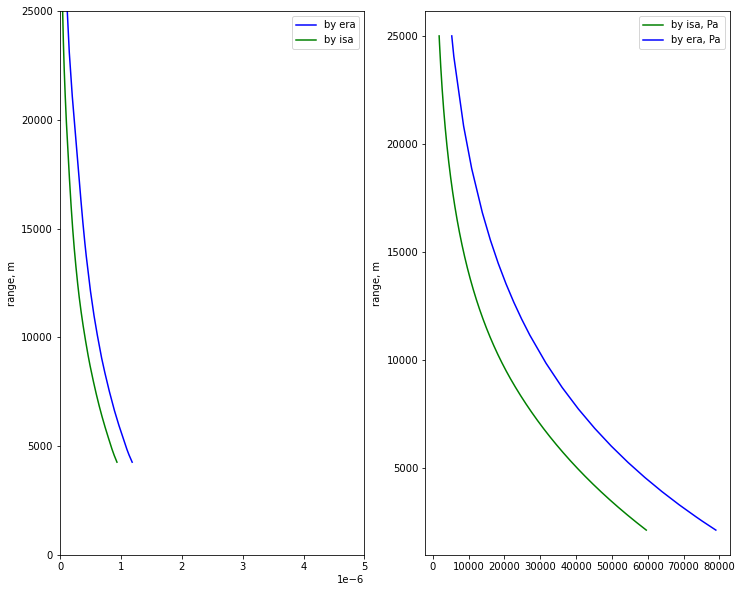

In [106]:
oparalt = oparraw['range']*1e3
#------Comparaison-------
fig, (ax,ax2)=plt.subplots(nrows=1, ncols=2,figsize=[12,10])
ax2.plot(pressure, pression.columns, label='by isa, Pa', color='g')
ax2.plot(pression.iloc[0,:], pression.columns, label='by era, Pa', color='b')
ax2.legend(loc=0)
ax2.set(ylabel='range, m')
ax.plot(molAttn1.iloc[0,:], np.array(molAttn1.columns)+2160, label='by era', color='b')
ax.plot(molAttn2, alt, label='by isa', color='g')
#ax.plot(oparatb.iloc[0,:], oparalt[:oparatb.shape[1]]+2160, label='atb', color='r')
ax.legend()
ax.set(ylabel='range, m')
ax.set_ylim(0,25000)
ax.set_xlim(0, 0.5e-5)

In [133]:
signal = oparraw['signal'][0,:,6] + oparraw['signal'][0,:,7]
oparalt = oparraw['range'].values*1e3
oparalt_ref = np.where((oparalt>=5000) & (oparalt<=5200))


In [146]:
m1= np.mean(signal[oparalt_ref[0]]/molAttn1.iloc[0,oparalt_ref[0]])
m2= np.mean(signal[oparalt_ref[0]]/molAttn2[oparalt_ref[0]])
print(m1, m2)

<xarray.DataArray ()>
array(1.03514865e+09)
Coordinates:
    time     datetime64[ns] 2019-01-21T16:45:08 <xarray.DataArray 'signal' ()>
array(1.52662051e+09)
Coordinates:
    time     datetime64[ns] 2019-01-21T16:45:08


new1 = signal/m1
new2 = signal/m2
print(new1[:molAttn1.shape[1]])


(0.0, 20000.0)

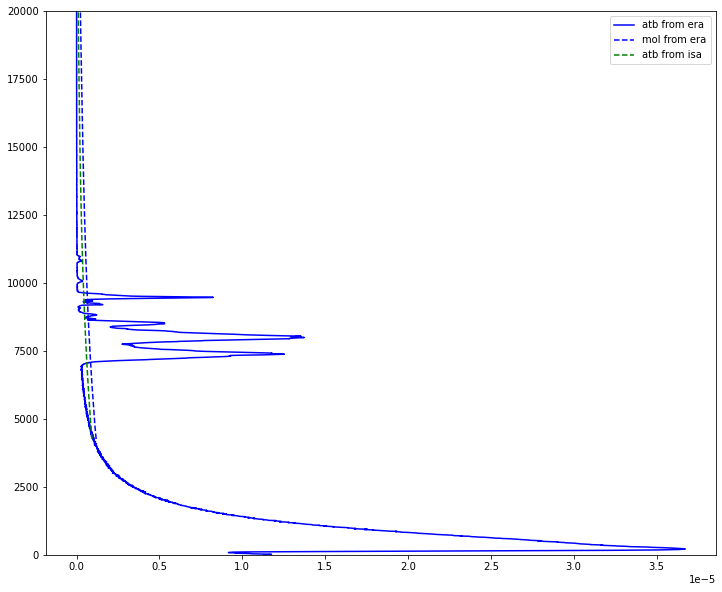

In [163]:
fig, ax = plt.subplots(figsize=[12,10])
ax.plot(new1, oparalt, label='atb from era', color='b')
#ax.plot(new2, oparalt, label='atb from isa', color='g')
ax.plot(molAttn1.iloc[0,:], np.array(molAttn1.columns)+2160, linestyle='--', label='mol from era', color='b')
ax.plot(molAttn2, alt, linestyle='--', label='atb from isa', color='g')
ax.legend()
ax.set_ylim(0,20000)